In [35]:
%matplotlib inline


# Visualizing learned state sequences and transition probabilities

Train a sticky HDP-HMM model on small motion capture data, then visualize the MAP state sequences under the estimated model parameters by running Viterbi.

Also has some info on how to inspect the learned HMM parameters of a sticky HDP-HMM model trained on small motion capture data.


In [2]:
# sphinx_gallery_thumbnail_number = 3

import bnpy
import numpy as np
import os

import matplotlib
from matplotlib import pylab
import seaborn as sns

np.set_printoptions(suppress=1, precision=3)

FIG_SIZE = (10, 5)
pylab.rcParams['figure.figsize'] = FIG_SIZE

Load dataset from file



In [19]:
import MoCap6
dataset = MoCap6.get_data()

In [3]:
dataset_path = os.path.join(bnpy.DATASET_PATH, 'mocap6')
dataset = bnpy.data.GroupXData.read_npz(
    os.path.join(dataset_path, 'dataset.npz'))

AttributeError: 'module' object has no attribute 'DATASET_PATH'

## Setup: Function to make a simple plot of the raw data



In [20]:
def show_single_sequence(
        seq_id,
        zhat_T=None,
        z_img_cmap=None,
        ylim=[-120, 120],
        K=5,
        left=0.2, bottom=0.2, right=0.8, top=0.95):
    if z_img_cmap is None:
        z_img_cmap = matplotlib.cm.get_cmap('Set1', K)

    if zhat_T is None:
        nrows = 1
    else:
        nrows = 2
    fig_h, ax_handles = pylab.subplots(
        nrows=nrows, ncols=1, sharex=True, sharey=False)
    ax_handles = np.atleast_1d(ax_handles).flatten().tolist()

    start = dataset.doc_range[seq_id]
    stop = dataset.doc_range[seq_id + 1]
    # Extract current sequence
    # as a 2D array : T x D (n_timesteps x n_dims)
    curX_TD = dataset.X[start:stop]
    for dim in range(12):
        ax_handles[0].plot(curX_TD[:, dim], '.-')
    ax_handles[0].set_ylabel('angle')
    ax_handles[0].set_ylim(ylim)
    z_img_height = int(np.ceil(ylim[1] - ylim[0]))
    pylab.subplots_adjust(
        wspace=0.1,
        hspace=0.1,
        left=left, right=right,
        bottom=bottom, top=top)
    if zhat_T is not None:
        img_TD = np.tile(zhat_T, (z_img_height, 1))
        ax_handles[1].imshow(
            img_TD,
            interpolation='nearest',
            vmin=-0.5, vmax=(K-1)+0.5,
            cmap=z_img_cmap)
        ax_handles[1].set_ylim(0, z_img_height)
        ax_handles[1].set_yticks([])

        bbox = ax_handles[1].get_position()
        width = (1.0 - bbox.x1) / 3
        height = bbox.y1 - bbox.y0
        cax = fig_h.add_axes([right + 0.01, bottom, width, height])
        cbax_h = fig_h.colorbar(
            ax_handles[1].images[0], cax=cax, orientation='vertical')
        cbax_h.set_ticks(np.arange(K))
        cbax_h.set_ticklabels(np.arange(K))
        cbax_h.ax.tick_params(labelsize=9)

    ax_handles[-1].set_xlabel('time')
    return ax_handles

## Visualization of the first sequence (1 of 6)



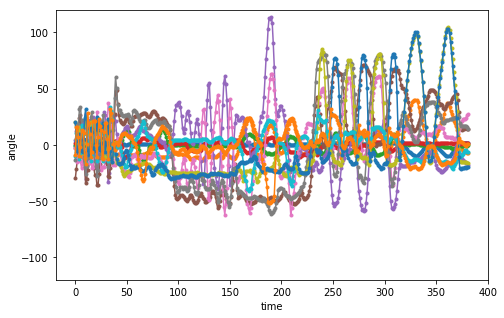

In [8]:
show_single_sequence(0)

## Setup: hyperparameters



In [21]:
K = 5            # Number of clusters/states

# Allocation model (HDP)
gamma      =   5.0  # top-level Dirichlet concentration parameter
transAlpha =   0.5  # trans-level Dirichlet concentration parameter 
startAlpha =  10.0  # starting-state Dirichlet concentration parameter
hmmKappa   =  50.0  # set sticky self-transition weight

# Observation model (1st-order Auto-regressive Gaussian)
sF = 1.0          # Set observation model prior so E[covariance] = identity
ECovMat = 'eye'

## Train HDP-HMM with *AutoRegGauss* observation model

Train single model for all 6 sequences.

Do small number of clusters jut to make visualization easy.

Take the best of 5 random initializations (in terms of evidence lower bound).




In [34]:
hdphmm_trained_model, hmmar_info_dict = bnpy.run(
    dataset, 'HDPHMM', 'AutoRegGauss', 'moVB',
    output_path=(
        '../tmp/mocap6/showcase-K=%d-model=HDPHMM+AutoRegGauss-ECovMat=1*eye/'
        % (K)),
    nLap=100, nTask=5, nBatch=1, convergeThr=0.0001,
    transAlpha=transAlpha, startAlpha=startAlpha, hmmKappa=hmmKappa,
    gamma=gamma,
    sF=sF, ECovMat=ECovMat,
    K=K, initname='randexamples',
    printEvery=25,
    )

## Visualize the starting-state probabilities

start_prob_K : 1D array, size K
    start_prob_K[k] = exp( E[log Pr(start state = k)] )



In [24]:
start_prob_K = hdphmm_trained_model.allocModel.get_init_prob_vector()

print(start_prob_K)

In [26]:
start_prob_K

array([0.354, 0.341, 0.044, 0.039, 0.03 ])

## Visualize the transition probabilities

trans_prob_KK : 2D array, K x K
    trans_prob_KK[j, k] = exp( E[log Pr(z_t = k | z_t-1 = j)] )




In [27]:
trans_prob_KK = hdphmm_trained_model.allocModel.get_trans_prob_matrix()

print(trans_prob_KK)

In [28]:
trans_prob_KK

array([[0.936, 0.035, 0.007, 0.018, 0.   ],
       [0.011, 0.936, 0.002, 0.036, 0.011],
       [0.007, 0.007, 0.978, 0.   , 0.003],
       [0.009, 0.051, 0.   , 0.861, 0.076],
       [0.011, 0.033, 0.001, 0.066, 0.883]])

## Compute log likelihood of each timestep for sequence 0

log_lik_TK : 2D array, T x K
    log_lik_TK[t, k] = E[ log Pr( observed data at time t | z_t = k)]



In [29]:
log_lik_seq0_TK = hdphmm_trained_model.obsModel.calcLogSoftEvMatrix_FromPost(
    dataset.make_subset([0])
    )

print(log_lik_seq0_TK[:10, :])

AttributeError: 'GroupXData' object has no attribute 'make_subset'

## Run Viterbi algorithm for sequence 0

zhat_T : 1D array, size T
    MAP state sequence
    zhat_T[t] = state assigned to timestep t, will be int value in {0, 1, ... K-1}



In [30]:
zhat_seq0_T = bnpy.allocmodel.hmm.HMMUtil.runViterbiAlg(
    log_lik_seq0_TK, np.log(start_prob_K), np.log(trans_prob_KK))

print(zhat_seq0_T[:10])

NameError: name 'log_lik_seq0_TK' is not defined

## Visualize the segmentation for sequence 0




In [31]:
show_single_sequence(0, zhat_T=zhat_seq0_T, K=K)

NameError: name 'zhat_seq0_T' is not defined

## Visualize the segmentation for sequence 1




In [ ]:
log_lik_seq1_TK = hdphmm_trained_model.obsModel.calcLogSoftEvMatrix_FromPost(
    dataset.make_subset([1])
    )
zhat_seq1_T = bnpy.allocmodel.hmm.HMMUtil.runViterbiAlg(
    log_lik_seq1_TK, np.log(start_prob_K), np.log(trans_prob_KK))

show_single_sequence(1, zhat_T=zhat_seq1_T, K=K)


pylab.show(block=False)